In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-20e972a3-2475-1098-af34-a34016395c65)


# Imports

In [4]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0999plmz
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0999plmz
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266461 sha256=085aa91c05d1b5900409ffe0b8fa07acb525b7c95bf49fae5999bd764b686c8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-yya1uz8r/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from skimage import transform
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import random
import math
from PIL import Image
import numpy as np
import os
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython import display
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
import scipy
import pickle
import random
from torchvision.models import alexnet, vgg19_bn
import json
import cv2
from random import shuffle

# Settings


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
main_path = '/content/drive/My Drive/BMI3/data/malaria'

In [8]:
%cd drive/My\ Drive/BMI3

/content/drive/My Drive/BMI3


In [9]:
# %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

In [10]:
from engine import train_one_epoch, evaluate
import utils

# Data

In [62]:
category = {    1: 'difficult',
                2 : 'gametocyte',
                3: 'leukocyte' ,
                4: 'red blood cell',
                5: 'ring',
                6: 'schizont',
                7: 'trophozoite' }


In [12]:
class customDataset(Dataset):
    def __init__(self, path, labeldict):
        X = []
        self.targets = []
        N = len(labeldict)
        for i in range(N):
            image = cv2.imread(path + labeldict[i]['image']['pathname'],cv2.IMREAD_GRAYSCALE) / 255
            image = self.unsharp(image)
            X.append([image.tolist()])
            
            boxes = [ ]
            inverse_cat = {     'difficult' : 1,
                                'gametocyte': 2,
                                'leukocyte' : 3,
                                'red blood cell': 4,
                                'ring': 5,
                                'schizont': 6,
                                'trophozoite': 7    }
            labels = []
            for j in range(len(labeldict[i]['objects'])):
                x0 = labeldict[i]['objects'][j]['bounding_box']['minimum']['c']
                y0 = labeldict[i]['objects'][j]['bounding_box']['minimum']['r']
                x1 = labeldict[i]['objects'][j]['bounding_box']['maximum']['c']
                y1 = labeldict[i]['objects'][j]['bounding_box']['maximum']['r']
                boxes.append([int(x0), int(y0), int(x1), int(y1)])
                label = labeldict[i]['objects'][j]['category']
                labels.append(inverse_cat[label])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            labels = torch.as_tensor(labels, dtype=torch.int64)

            image_id = torch.tensor([i])
            
            area =  (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            self.targets.append(target)
        self.X = torch.FloatTensor(X)



    def unsharp (self, image):
        kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])
        sharpened = cv2.filter2D(image, -1, kernel)
        return sharpened


    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, idx):
        item = self.X[idx]
        target = self.targets[idx]
        return item, target

In [13]:
with open(main_path +'/training.json') as train_file:
    dict_train = json.load(train_file)

shuffle(dict_train)
dict_train = dict_train[:300]


with open(main_path +'/test.json') as test_file:
    dict_test = json.load(test_file)

# dict_test = dict_test[:80]

dataset_train = customDataset (main_path, dict_train)
dataset_test = customDataset (main_path, dict_test)


In [14]:
data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

# Model

In [50]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained= False)

num_classes = 8  # 7 class  + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### input is grayscale with one channel
model.backbone.body.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

anchor_generator = AnchorGenerator(sizes=((8, 16, 32),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# model.rpn.anchor_generator = anchor_generator

model.transform = torchvision.models.detection.transform.GeneralizedRCNNTransform(min_size=(800,), max_size=1333, image_mean=[0.485], image_std= [0.229])


In [63]:
model = model.to(device)

# Train

In [52]:
def train():

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

   
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)
       

In [53]:
train()

Epoch: [0]  [  0/150]  eta: 0:07:10  lr: 0.000039  loss: 3.4069 (3.4069)  loss_classifier: 2.0741 (2.0741)  loss_box_reg: 0.4764 (0.4764)  loss_objectness: 0.6921 (0.6921)  loss_rpn_box_reg: 0.1642 (0.1642)  time: 2.8720  data: 2.4946  max mem: 4228
Epoch: [0]  [ 10/150]  eta: 0:01:21  lr: 0.000374  loss: 3.3949 (3.3754)  loss_classifier: 2.0550 (2.0395)  loss_box_reg: 0.4801 (0.5029)  loss_objectness: 0.6922 (0.6921)  loss_rpn_box_reg: 0.1481 (0.1409)  time: 0.5818  data: 0.2309  max mem: 4228
Epoch: [0]  [ 20/150]  eta: 0:01:01  lr: 0.000709  loss: 3.1497 (3.1282)  loss_classifier: 1.8881 (1.7589)  loss_box_reg: 0.5622 (0.5626)  loss_objectness: 0.6890 (0.6793)  loss_rpn_box_reg: 0.1184 (0.1275)  time: 0.3517  data: 0.0045  max mem: 4228
Epoch: [0]  [ 30/150]  eta: 0:00:51  lr: 0.001044  loss: 2.4503 (2.8528)  loss_classifier: 1.0692 (1.4744)  loss_box_reg: 0.6590 (0.6209)  loss_objectness: 0.6102 (0.6358)  loss_rpn_box_reg: 0.1074 (0.1217)  time: 0.3512  data: 0.0045  max mem: 4228


In [83]:
# pick one image from the test set
img, targets = dataset_test[95]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [84]:
boxes = prediction[0]['boxes'].tolist()
labels = prediction[0]['labels'].tolist()
g_boxes = targets['boxes'].tolist()
g_labels = np.array(targets['labels'].tolist())

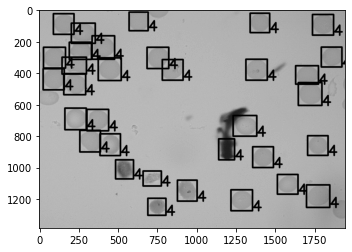

In [85]:
img = np.array(img.tolist()[0])
img0_clone = np.copy(img)
bbox0 = np.array(boxes) 
bbox1 = np.array(g_boxes, dtype =int)
labels = np.array(labels) 

for i in range(len(bbox0)):
    # cv2.rectangle(img0_clone, (int(bbox0[i][1]), int(bbox0[i][0])), (int(bbox0[i][3]), int(bbox0[i][2])), color=(255, 255, 255), thickness=10) 
    cv2.rectangle(img0_clone, (int(bbox0[i][0]), int(bbox0[i][1])), (int(bbox0[i][2]), int(bbox0[i][3])), color=(0,0,0), thickness=10) 
    cv2.putText(img0_clone, str(labels[i]), (int(bbox0[i][2]), int(bbox0[i][3])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness= 10) 
plt.imshow(img0_clone, cmap='gray')
plt.show()    


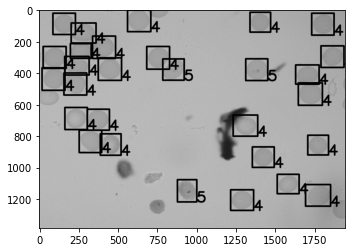

In [86]:
img0_clone = np.copy(img)
for i in range(len(bbox1)):
    cv2.rectangle(img0_clone, (int(bbox1[i][0]), int(bbox1[i][1])), (int(bbox1[i][2]), int(bbox1[i][3])), color=(0,0,0), thickness=10) 
    # cv2.rectangle(img0_clone, (int(bbox0[i][1]), int(bbox0[i][0])), (int(bbox0[i][3]), int(bbox0[i][2])), color=(0, 0, 0), thickness=10) 
    cv2.putText(img0_clone, str(g_labels[i]), (int(bbox1[i][2]), int(bbox1[i][3])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness= 10) 
plt.imshow(img0_clone, cmap='gray')
plt.show()  

In [60]:
torch.save(model, 'model.pt')